In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

## Questão 1

### Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa). Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/4353

In [2]:
dataset = np.genfromtxt('./concrete.csv', delimiter=',', skip_header=0)

#### a) Considere um modelo de regressão não linear baseado em redes neurais articiais. Separe os dados aleatoriamente em treino, validação e teste(por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  

In [3]:
x_train, x_test_tmp, y_train, y_test_tmp = train_test_split(dataset[:,:-1],dataset[:,-1],train_size=0.6)
x_val, x_test,y_val, y_test = train_test_split(x_test_tmp,y_test_tmp, train_size=0.5)

In [4]:
#normalizar dados
nomalizador_x = StandardScaler().fit(x_train)
x_train = nomalizador_x.transform(x_train)
x_val = nomalizador_x.transform(x_val)
#x_test = nomalizador_x.transform(x_test)

nomalizador_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train = nomalizador_y.transform(y_train.reshape(-1,1))
y_val = nomalizador_y.transform(y_val.reshape(-1,1))
#y_test = nomalizador_y.transform(y_test.reshape(-1,1))




#### MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros. 

In [23]:
#inicias hiper parametros
minibatch = 20
momentum = 0.9
alpha = 0.001
hidden_nodes = 5
epoches = 50
#weigh_decay = 0

In [24]:
def foward(x_):
    z_ = []
    for nh in range(hidden_nodes):
        zs = []      
        for i in range(x_.shape[0]):
            u = W[nh].T@x_[i]
            z = np.tanh(u)            
            zs.append(z)
        z_.append(zs)
        
    z_ = np.array(z_)    
    z_ = np.concatenate((np.ones(x_.shape[0]).reshape(1,-1),z_),axis=0)
    
    return z_

def calculaErro(y, o, n):
    e = (y-o.reshape(-1,1))    
    j = np.sum((y-o.reshape(-1,1))**2)/(2*n)
    return e, j


In [25]:
x_ = np.c_[np.ones(x_train.shape[0]),x_train]
K = 1
j_history = []
delta = 0

#inicializar os pesos
lim_m =  np.sqrt(1/(hidden_nodes+1))
m = np.random.uniform(-lim_m,lim_m,size=(hidden_nodes+1))
m[0] = np.mean(y_train)

lim_w = np.sqrt(1/((hidden_nodes+1)*x_.shape[1]))
W = np.random.uniform(-lim_w,lim_w, size=(hidden_nodes+1,x_.shape[1]))
W[:,0] = 0

for epoch in range(epoches):
    
    #treino
    z_ = foward(x_) 
    o = m.T@z_ 

    #Calcula o erro
    e, j = calculaErro(y_train, o, x_train.shape[0])  
    

    #Validação
    z_val = foward(np.c_[np.ones(x_val.shape[0]),x_val]) 
    o_val = m.T@z_val

    #Calcula o erro
    e_val, j_val = calculaErro(y_val, o_val, x_val.shape[0])
    

    j_history.append([j, j_val])

    #atualiza os parametros    
    m += (alpha * e[:,0].T)@ z_.T    
    ç = ((1-z_**2).T * m).T *e[:,0]    
    delta = momentum*delta - ((ç@x_)*alpha)
    W += delta  

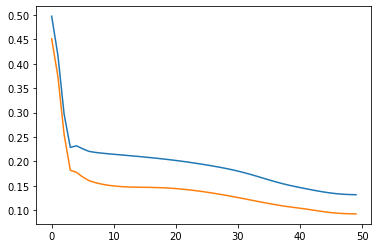

In [26]:
plt.plot(j_history)

In [27]:
#Retreino com treino + val
x_tv = np.concatenate((x_train, x_val))
y_tv = np.concatenate((y_train, y_val))
delta = 0
#inicializar os pesos
x_ = np.c_[np.ones(x_tv.shape[0]),x_tv]
lim_m =  np.sqrt(1/(hidden_nodes+1))
m = np.random.uniform(-lim_m,lim_m,size=(hidden_nodes+1))
m[0] = np.mean(y_tv)

lim_w = np.sqrt(1/((hidden_nodes+1)*x_.shape[1]))
W = np.random.uniform(-lim_w,lim_w, size=(hidden_nodes+1,x_.shape[1]))
W[:,0] = 0

#Treinamento
for epoch in range(epoches):
    #treino
    z_ = foward(x_) 
    o = m.T@z_ 

    #Calcula o erro
    e, j = calculaErro(y_tv, o, x_tv.shape[0])

    #atualiza os parametros    
    m += (alpha * e[:,0].T)@ z_.T    
    ç = ((1-z_**2).T * m).T *e[:,0]    
    delta = momentum*delta - ((ç@x_)*alpha)
    W += delta

#Test
z_test =foward(np.c_[np.ones(x_test.shape[0]),x_test]) 
prev = nomalizador_y.inverse_transform(m.T@z_test)

In [33]:
def rmse(y, pred):
    return np.sqrt(np.mean((y - pred)**2))

def mae(y, pred):
    return np.mean(np.abs(y-pred))

def mre(y, pred):
    return np.mean(np.abs((y-pred)/y))

In [34]:
print('Obtivemos o seguinte RMSE para treino: ',rmse(nomalizador_y.inverse_transform(y_train),nomalizador_y.inverse_transform(o)))
print('Obtivemos o seguinte RMSE para Validação: ',rmse(nomalizador_y.inverse_transform(y_val),nomalizador_y.inverse_transform(o_val)))
print('Obtivemos o seguinte RMSE para Teste: ',rmse(y_test,prev))

Obtivemos o seguinte RMSE para treino:  21.451889466809106
Obtivemos o seguinte RMSE para Validação:  21.616495965398734
Obtivemos o seguinte RMSE para Teste:  15.685014531164322


In [35]:
print('Obtivemos o seguinte MAE para treino: ',mae(nomalizador_y.inverse_transform(y_train),nomalizador_y.inverse_transform(o)))
print('Obtivemos o seguinte MAE para Validação: ',mae(nomalizador_y.inverse_transform(y_val),nomalizador_y.inverse_transform(o_val)))
print('Obtivemos o seguinte MAE para Teste: ',mae(y_test,prev))

Obtivemos o seguinte MAE para treino:  17.382220478449344
Obtivemos o seguinte MAE para Validação:  17.472177444463533
Obtivemos o seguinte MAE para Teste:  12.165234241482995


In [36]:
print('Obtivemos o seguinte MRE para treino: ',mre(nomalizador_y.inverse_transform(y_train),nomalizador_y.inverse_transform(o)))
print('Obtivemos o seguinte MRE para Validação: ',mre(nomalizador_y.inverse_transform(y_val),nomalizador_y.inverse_transform(o_val)))
print('Obtivemos o seguinte MRE para Teste: ',mre(y_test,prev))

Obtivemos o seguinte MRE para treino:  0.701745101399791
Obtivemos o seguinte MRE para Validação:  0.7741878877655581
Obtivemos o seguinte MRE para Teste:  0.5201103046547207
